# Лабораторная работа 2

## Решение СЛАУ разными методами

In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sp
import pandas as pd

### Задача:

Решить выбранную СЛАУ следующими методами: 

1) метод Гаусса с выбором главного элемента
2) метод LU-разложения
3) метод Якоби
4) метод Зейделя
5) метод верхней релаксации
6) * Метод градиентного спуска
7) * Метод минимальных невязок
8) * Стабилизированный метод
бисопряженных градиентов

* Для итерационных методов получить график убывания невязки в зависимости от итерации.


### Исходная СЛАУ:
![Исходная СЛАУ](imgs/slau.png "Title")

In [2]:
def init_matrixes():
    i_max = 100
    
    a    = lambda i: 10
    b_ij = lambda i: 1/i
    f_i  = lambda i: i

    matxA = np.zeros((i_max, i_max))
    matxF = np.arange(1, i_max+1)

    def fill_matxA(mx):
        num_rows, num_cols = mx.shape
        for row in range(num_rows):
            for col in range(num_cols):
                if row > col:
                    mx[row][col] = b_ij(row+1)
                elif row == col:
                    mx[row][col] = a(row+1)
                elif row + 1 == col and row + 1 < i_max:
                    mx[row][col] = b_ij(row+1)
    
    fill_matxA(matxA)
    
    return matxA, matxF

def dump_matrix(matrix):
    display(pd.DataFrame(matrix))

# A, f = init_matrixes()
# dump_matrix(A)
# dump_matrix(f)

In [3]:
def norm_vec(vec):
    return np.linalg.norm(vec, ord=np.inf)

def mat_norm(matrix):
    return np.linalg.norm(matrix, ord=np.inf)

threshold = 1e-10

def check_res(A, u, f, eps=threshold):
    norm = norm_vec(np.matmul(A, u) - f)
    return norm, abs(norm) < eps


In [4]:
# метод Гаусса с выбором главного элемента (Gaussian method with principal element selection)
def Gauss_princ_select(matxA, f):
    n, _ = matxA.shape
    aug_matrix = np.hstack((matxA, f.reshape(n, 1)))
    
    for nrow in range(n):
        pivot = nrow + np.argmax(abs(aug_matrix[nrow:, nrow]))
        if pivot != nrow:
            aug_matrix[nrow], aug_matrix[pivot] = aug_matrix[pivot], np.copy(aug_matrix[nrow])
        row = aug_matrix[nrow]
        divider = row[nrow]
        if abs(divider) < threshold:
            return None
        row /= divider
        
        for lower_row in aug_matrix[nrow + 1:]:
            mul_coeff = lower_row[nrow]
            lower_row -= mul_coeff * row
    
    for nrow in range(n - 1, 0, -1):
        row = aug_matrix[nrow]
        for upper_row in aug_matrix[:nrow]:
            factor = upper_row[nrow]
            
            upper_row[-1] -= factor*row[-1]
            upper_row[nrow] = 0
            
    return aug_matrix[:,-1]

# A, f = init_matrixes()
# u = Gauss_princ_select(A, f)

# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [5]:
# метод LU-разложения (LU decomposition method)
def LU_decomposition(matxA):
    n, _ = matxA.shape
    L = np.eye(n)
    U = np.copy(matxA)

    for i in range(n - 1):
        for j in range(i + 1, n):
            L[j, i] = U[j, i] / U[i, i]
            U[j] -= L[j, i] * U[i]

    return L, U

def slaeLU_dec(matxA, f):
    L, U = LU_decomposition(matxA)
    n = f.shape[0]
    y = np.zeros(n)
    x = np.zeros(n)
    
    # solve L*y=b
    for i in range(n):
        sum_ly = 0
        for k in range(i - 1):
            sum_ly += L[i][k] * y[k]
        y[i] = f[i] - sum_ly

    # solve U*x=y
    for i in range(n - 1, -1, -1):
        sum_ux = 0
        for k in range(i + 1, n):
            sum_ux += U[i][k] * x[k]
        x[i] = (y[i] - sum_ux) / U[i][i]

    return x

# A, f = init_matrixes()
# u = slaeLU_dec(A, f)

# norm, comp = check_res(A, u, f, 0.1)
# print(norm)
# print(comp)


In [6]:
# метод Якоби
def Jacobi(matxA, f, x0=None, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = None
    
    if not x0:
        x = np.zeros(n)
    else:
        x = np.copy(x0)

    diff = []
    for k in range(max_iter):
        x_prev = np.copy(x)
        for i in range(n):
            sum_left = 0
            sum_right = 0
            for j in range(i):
                sum_left += matxA[i, j] * x_prev[j]
            for j in range(i + 1, n):
                sum_right += matxA[i, j] * x_prev[j]
            x[i] = (f[i] - sum_left - sum_right) / matxA[i, i]
    
        if mat_norm(x - x_prev) < eps:
            break
            
        if ref_root is not None:
                diff.append(norm_vec(x - ref_root))
    
    return x, diff

# A, f = init_matrixes()
# u = Jacobi(A, f)

# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [7]:
# метод Зейделя
def Seidel(matxA, f, x0=None, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = None
    
    if not x0:
        x = np.zeros(n)
    else:
        x = np.copy(x0)

    diff = []
    for k in range(max_iter):
        x_prev = np.copy(x)
        for i in range(n):
            sum_left = 0
            sum_right = 0
            for j in range(i):
                sum_left += matxA[i, j] * x[j]
            for j in range(i + 1, n):
                sum_right += matxA[i, j] * x_prev[j]
            x[i] = (f[i] - sum_left - sum_right) / matxA[i, i]
    
        if mat_norm(x - x_prev) < eps:
            break

        if ref_root is not None:
                diff.append(norm_vec(x - ref_root))
    
    return x, diff

# A, f = init_matrixes()
# u = Seidel(A, f)
    
# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [8]:
# метод верхней релаксации (successive over-relaxation )
def SOR(matxA, f, omega=0.01, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = np.zeros(n)

    diff = []
    for k in range(max_iter):
        x_prev = np.copy(x)
        for i in range(n):
            sigma = 0
            for j in range(i):
                sigma += matxA[i, j] * x[j]
            for j in range(i + 1, n):
                sigma += matxA[i, j] * x_prev[j]
            
            sigma = (f[i] - sigma) / matxA[i][i]
            x[i] = x_prev[i] + omega * (sigma - x_prev[i])
    
        if mat_norm(x - x_prev) < eps:
            break
        if ref_root is not None:
                diff.append(norm_vec(x - ref_root))
    
    return x, diff

# ref_roots = np.linalg.solve(A, f)
# A, f = init_matrixes()
# u, diff = SOR(A, f, max_iter=10, omega=1.03, ref_root=ref_roots)
# print(diff)
# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [49]:
# Квадратичный метод сопряженных градиентов (Quadratic conjugate gradient method)
def quadr_conj_grad_desc(matxA, f, x0=None, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = None
    if x0 is None:
        x = np.zeros(n)
    else:
        x = np.copy(x0)
    r0 = f - np.matmul(matxA, x)
    r = np.copy(r0)
    r_ = np.copy(r)
    rho_prev = None 

    M = np.copy(matxA) + 0.1

    diff = []
    for i in range(max_iter):
        rho = np.dot(r_, r)
        if rho == 0:
            return None
        if i == 0:
            u = np.copy(r0)
            p = np.copy(u)
        else:
            betta = rho / rho_prev
            u = r + betta * q
            p = u + betta * (q + betta * p)

        # find p_ from M*p_ = p
        p_, _ = Seidel(M, p)
        v_ = np.matmul(matxA, p_)
        alpha = rho / np.dot(r_, v_)
        q = u - alpha * v_

        # find u_ from M * u_ = u + q
        u_, _ = Seidel(M, u + q)
        x = x + alpha * u_

        q_ = np.matmul(matxA, u_)
        r = r - alpha * q_
        
        if ref_root is not None:
            diff.append(norm_vec(x - ref_root))
            
        if norm_vec(r)/norm_vec(r0) < eps:
            break

        rho_prev = rho

    return x, diff

# ref_roots = np.linalg.solve(A, f)
# A, f = init_matrixes()
# u, diff = quadr_conj_grad_desc(A, f, ref_root=ref_roots, eps=1e-15, max_iter=100)
# print(diff)
# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [10]:
# Метод минимальных невязок (Minimum residual method)
def min_res(matxA, f, x0=None, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = None
    if not x0:
        x = np.zeros(n)
    else:
        x = np.copy(x0)

    diff = []
    for i in range(max_iter):
        residual = np.dot(matxA, x) - f
        A_r = np.dot(matxA, residual)
        alpha = np.dot(A_r, residual) / np.dot(A_r, A_r)
        x = x - alpha * residual

        if ref_root is not None:
            diff.append(norm_vec(x - ref_root))
            
        if mat_norm(alpha * residual) < eps:
            break

    return x, diff

# A, f = init_matrixes()
# u = min_res(A, f)

# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)

In [11]:
# Стабилизированный метод бисопряженных градиентов (Stabilized biconjugate gradient method)
def stab_biconjugate_grad(matxA, f, x0=None, max_iter=100, eps=threshold, ref_root=None):
    n = f.shape[0]
    x = None
    if not x0:
        x = np.zeros(n)
    else:
        x = np.copy(x0)

    r = f - np.matmul(matxA, x)
    rho = 1
    alpha = 1
    omega = 1
    r_ = r
    nu = np.zeros(n)
    p = np.zeros(n)

    diff = []
    for i in range(max_iter):
        rho_prev = rho
        rho = np.dot(r_, r)
        betta = (rho/rho_prev) * (alpha/omega)

        p = r + betta * (p - omega * nu)
        nu = np.matmul(matxA, p)

        alpha = rho / np.dot(r_, nu)
        s = r - alpha * nu
        t = np.matmul(A, s)
        omega = np.dot(t, s) / np.dot(t, t)
        x = x + alpha * p + omega * s
            
        r = s - omega * t

        if ref_root is not None:
            diff.append(norm_vec(x - ref_root))
            
        if norm_vec(r) / norm_vec(f) < eps:
            break

    return x, diff

# A, f = init_matrixes()
# u = stab_biconjugate_grad(A, f)

# norm, comp = check_res(A, u, f)
# print(norm)
# print(comp)
    

### Заключение

[np.float64(1.8331278113275156), np.float64(1.1244616349159742e-12), np.float64(6.608602554081244e-14), np.float64(8.881784197001252e-15), np.float64(8.881784197001252e-15), np.float64(8.881784197001252e-15)]


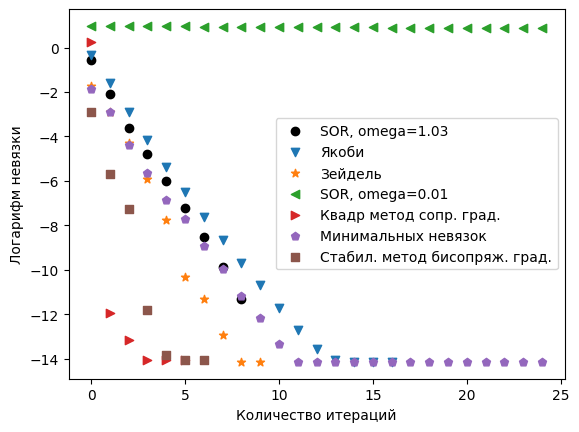

In [50]:

def create_scatter(method, ref_roots, max_iter, eps, method_name, mark, x0=None):
    A, f = init_matrixes()
    if x0 is not None:
        u, diff = method(A, f, x0=x0.all(), max_iter = max_iter, eps=eps, ref_root=ref_roots)
    else:
        u, diff = method(A, f, max_iter = max_iter, eps=eps, ref_root=ref_roots)

    plt.scatter(range(0, len(diff)), np.log10(diff), label=method_name, marker=mark)


A, f = init_matrixes()
ref_roots = np.linalg.solve(A, f)

A, f = init_matrixes()
u, diff = SOR(A, f, max_iter=10, omega=1.03, ref_root=ref_roots)
plt.scatter(range(0, len(diff)), np.log10(diff), label="SOR, omega=1.03", color='black')

create_scatter(Jacobi, ref_roots, 25, 1e-18, "Якоби", "v")
create_scatter(Seidel, ref_roots, 25, 1e-18, "Зейдель", "*")
create_scatter(SOR, ref_roots, 25, 1e-18, "SOR, omega=0.01", "<")
# x0 = np.linspace(0, 1, num=100)
create_scatter(quadr_conj_grad_desc, ref_roots, 25, 1e-18, "Квадр метод сопр. град.", ">")
create_scatter(min_res, ref_roots, 25, 1e-18, "Минимальных невязок", "p")
create_scatter(stab_biconjugate_grad, ref_roots, 25, 1e-18, "Стабил. метод бисопряж. град.", "s")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()
